<a href="https://colab.research.google.com/gist/sblot2/4804a903007574eaf06d6ce870e35989/deep-learning-work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Import**

We first start by importing the packages that we will need. We then import our dataset as a csv file.

In [0]:

import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(250620279)
%matplotlib inline

In [0]:

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Reshape, MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Downloading the data using gdown
! gdown  https://drive.google.com/uc?id=1L0mjAKUJI7-FOeov2UuHGdLhtgB7Rs85

full_data = pd.read_csv('/content/Full_Data.csv')

Downloading...
From: https://drive.google.com/uc?id=1L0mjAKUJI7-FOeov2UuHGdLhtgB7Rs85
To: /content/Full_Data.csv
38.4MB [00:00, 74.4MB/s]


In [0]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204058 entries, 0 to 204057
Data columns (total 3 columns):
text          204058 non-null object
sentiment     204058 non-null int64
confidence    204058 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ MB


We download our first imbedding which will be the fasttext imbedding. 

In [0]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
  
!unzip v0.9.1.zip

--2019-12-16 20:18:15--  https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1 [following]
--2019-12-16 20:18:16--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.1.zip’

v0.9.1.zip              [    <=>             ]   4.13M  5.40MB/s    in 0.8s    

2019-12-16 20:18:17 (5.40 MB/s) - ‘v0.9.1.zip’ saved [4327207]

Archive:  v0.9.1.zip
b5b7d307274ce00ef52198fbc692ed3bd11d9856
   creating: fastText-0.9.1/
   creating: fastText-0.9.1/.circleci/
  inflating: fastText-0

We then compile the library as follows:

In [0]:
%cd fastText-0.9.1

!make

/content/fastText-0.9.1
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/meter.cc
c++ -pthread -std=c++0x -march=native -O3 -fun

We now move to downloading our embedding vectors. We choose the vectors trained over Wikipedia 

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  
!gunzip -v -f cc.en.300.bin.gz

--2019-12-16 20:18:36--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  9.50MB/s    in 7m 28s  

2019-12-16 20:26:06 (9.58 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

cc.en.300.bin.gz:	 37.8% -- replaced with cc.en.300.bin


**Data Preprocessing**

We take our csv file and convert it into a dataframe

In [0]:
data1 = pd.DataFrame(full_data)
data1.head()

,text,sentiment,confidence
0,trying to wait a patient as i can lol,1,0.3
1,"Good morning Fotopro Team, I noticed in some ...",1,0.6
2,these still on track? ahead? behind?,1,0.2
3,any update on delivery?,1,0.0
4,product so nice had to get it twice,1,0.5


In [0]:

%cd /content

/content


We first note that URLs will  not serve any purpose in predicting sentiments. We therefore remove them

In [0]:
import re
data1.iloc[:,0] = [re.sub(r'\b(?:(?:https?|ftp)://)?\w[\w-]*(?:\.[\w-]+)+\S*', '', j) for j in data1.iloc[:,0]]

We then clean our data by removing all of the special characters

In [0]:
import string
from string import digits 

table = str.maketrans(' ', ' ', string.punctuation)

data1.iloc[:,0] = [j.translate(table) for j in data1.iloc[:,0]]
data1.iloc[:,0] = [j.replace('\x96',' ') for j in data1.iloc[:,0]]
data1.iloc[:,0] = [" ".join(j.split()) for j in data1.iloc[:,0]]


In [0]:
data1.head()

,text,sentiment,confidence,Num_Count,Phrase_Length
0,trying wait patient as i can lol,1,0.3,0,9
1,good morning fotopro team noticed in some comm...,1,0.6,1,33
2,these still on track ahead behind,1,0.2,0,6
3,any update on delivery,1,0.0,0,4
4,product so nice had get twice,1,0.5,0,8


Counting the number of digits per sentence


In [0]:
def num_count(phrase):
  num = sum(word.isdigit() for word in phrase)
  return num

data1['Num_Count'] = data1.apply(lambda x: num_count(x['text']), axis = 1)


data1.Num_Count.describe()



count    204058.000000
mean          0.857119
std           2.529920
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         128.000000
Name: Num_Count, dtype: float64

Text(0.5, 1.0, 'Histogram of amount of numbers per sentence')

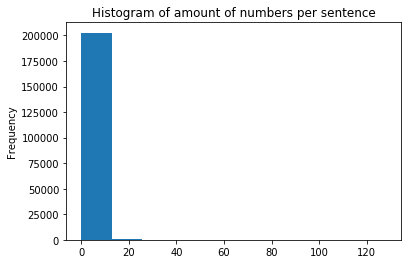

In [0]:
data1['Num_Count'].plot(
    kind = 'hist')

plt.title("Histogram of amount of numbers per sentence")

We remove the digit from the sentences

In [0]:
table = str.maketrans(' ', ' ', digits)

data1.iloc[:,0] = [j.translate(table) for j in data1.iloc[:,0]]
data1.iloc[:,0] = [j.replace('\x96',' ') for j in data1.iloc[:,0]]

data1.iloc[:,0] = [" ".join(j.split()) for j in data1.iloc[:,0]]

In [0]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204058 entries, 0 to 204057
Data columns (total 5 columns):
text             204058 non-null object
sentiment        204058 non-null int64
confidence       204058 non-null float64
Num_Count        204058 non-null int64
Phrase_Length    204058 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.8+ MB


Avg. no of words: 29.88
Std. deviation: 28.31
Max words: 1243


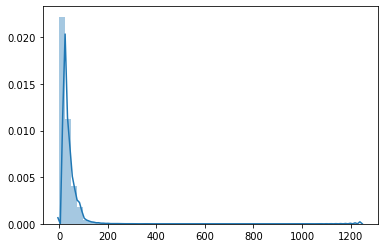

In [0]:
import seaborn as sns
import numpy as np
%matplotlib inline


wordDist = [len(w.split()) for w in data1.iloc[:,0]]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))


distIMDB = sns.distplot(wordDist)


distIMDB.figure.savefig("wordDist.pdf", format = "pdf")

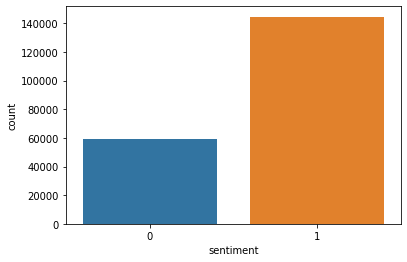

In [0]:
import seaborn as sns

sns.countplot(x='sentiment', data=data1)

**Inferences from Data**

Counting the number of words per sentence

In [0]:
def phrase_len(phrase):
  out = len(str(phrase).split(" "))
  return out

data1['Phrase_Length'] = data1.apply(lambda x: phrase_len(x['text']), axis = 1)
data1.head()


data1.Phrase_Length.describe()


count    204058.000000
mean         29.882176
std          28.309064
min           1.000000
25%          12.000000
50%          22.000000
75%          39.000000
max        1243.000000
Name: Phrase_Length, dtype: float64

Counting the number of characters per sentence

In [0]:
def char_num(phrase):
  space_num = phrase.count(' ')
  out = len(phrase) - space_num
  return out

data1['Char_Num'] = data1.apply(lambda x: char_num(x['text']), axis = 1)
data1

data1.Char_Num.describe()


count    204058.000000
mean        128.859849
std         123.445343
min           0.000000
25%          50.000000
50%          93.000000
75%         168.000000
max        5415.000000
Name: Char_Num, dtype: float64

In [0]:
num1 = pd.Series(' '.join(data1['text']).split()).value_counts()[:10]
num1


the    266399
to     187024
I      152468
and    128655
a      120531
you     99485
for     84939
of      79891
it      76226
is      74191
dtype: int64

In [0]:
num2 = pd.Series(' '.join(data1['text']).split()).value_counts()[-10:]
num2 

bikeshelf        1
gursikh          1
Hillery          1
configuarion     1
appearanceno     1
conductor’s      1
shipusereturn    1
quipped          1
Goofy            1
Stoopid          1
dtype: int64

Counting the number of uppercase characters per sentence


In [0]:
def upper_count(phrase):
  upper = sum(word.isupper() for word in phrase)
  return upper

upper_count("Sankara IS handSSome 3daD")

data1['Upper_Count'] = data1.apply(lambda x: upper_count(x['text']), axis = 1)

data1
data1.Upper_Count.describe()


count    204058.000000
mean          5.461511
std          14.617812
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max        5415.000000
Name: Upper_Count, dtype: float64

In [0]:
upper_count("SankaraDA")

3

Counting the number of lowercase characters per sentence

In [0]:
def lower_count(phrase):
  lower = sum(word.islower() for word in phrase)
  return lower

data1['Lower_Count'] = data1.apply(lambda x: lower_count(x['text']), axis = 1)

data1
data1.Lower_Count.describe()


count    204058.000000
mean        123.274672
std         119.019976
min           0.000000
25%          47.000000
50%          89.000000
75%         161.000000
max        5320.000000
Name: Lower_Count, dtype: float64

In [0]:
lower_count("Sankara IS handSSome 3daD")


15

Most frequent words

**Data Processing**

We modify our text variable by removing the words that are the most repeated and the words that are the least repeated

In [0]:
num_1 = list(num1.index)
num_1

data1['text'] = data1['text'].apply(lambda x: " ".join(x for x in x.split() if x not in num_1))



In [0]:
num_2 = list(num2.index)
num_2

data1['text'] = data1['text'].apply(lambda x: " ".join(x for x in x.split() if x not in num_2))

For simplicity, we then convert all of the characters into lower case characters

In [0]:
data1.head()

,text,sentiment,confidence,Num_Count,Phrase_Length,Char_Num,Upper_Count,Lower_Count
0,trying wait patient as i can lol,1,0.3,0,9,29,0,29
1,Good morning Fotopro Team noticed in some comm...,1,0.6,1,33,141,7,134
2,these still on track ahead behind,1,0.2,0,6,28,0,28
3,any update on delivery,1,0.0,0,4,19,0,19
4,product so nice had get twice,1,0.5,0,8,28,0,28


In [0]:
data1['text'] = data1['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [0]:
data1.head()

,text,sentiment,confidence,Num_Count,Phrase_Length,Char_Num,Upper_Count,Lower_Count
0,trying wait patient as i can lol,1,0.3,0,9,29,0,29
1,good morning fotopro team noticed in some comm...,1,0.6,1,33,141,7,134
2,these still on track ahead behind,1,0.2,0,6,28,0,28
3,any update on delivery,1,0.0,0,4,19,0,19
4,product so nice had get twice,1,0.5,0,8,28,0,28


In [0]:
data1

,text,sentiment,confidence,Num_Count,Phrase_Length,Char_Num,Upper_Count,Lower_Count
0,trying wait patient as i can lol,1,0.3,0,9,29,0,29
1,good morning fotopro team noticed in some comm...,1,0.6,1,33,141,7,134
2,these still on track ahead behind,1,0.2,0,6,28,0,28
3,any update on delivery,1,0.0,0,4,19,0,19
4,product so nice had get twice,1,0.5,0,8,28,0,28
...,...,...,...,...,...,...,...,...
204053,im curious if youve looked at working with par...,1,0.7,1,39,188,8,180
204054,looking forward another awesome campaign kevin...,1,1.7,0,15,70,5,65
204055,nice thanks all answers cheers,1,1.4,0,6,29,3,26
204056,wink was still amazing was less enthusiast abo...,1,1.7,0,42,177,9,168


In [0]:
confidence_avg = np.mean(data1['confidence'])
confidence_avg

data2 = data1[data1['confidence']>confidence_avg]
data2.head()

,text,sentiment,confidence,Num_Count,Phrase_Length,Char_Num,Upper_Count,Lower_Count
7,looking forward many uses this product am an e...,1,1.1,0,33,136,1,135
8,hi looking forward getting this product what s...,1,1.2,0,78,315,10,305
19,imran thank so much we are all so excited,1,1.3,0,10,36,3,33
29,received stencils in france there were no addi...,1,2.0,0,25,117,4,113
31,hi its great just received mine im pretty exit...,1,2.0,0,39,154,8,146


**Embedding**

FastText

In [0]:
import codecs

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(data2.iloc[:,0])

Vals = list(tokenizer.word_index.keys())

file = codecs.open('data2.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)
    
file.close()


In [0]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < data2.csv > Embeddingdata2.tsv

tcmalloc: large alloc 4800004096 bytes == 0x562aba04a000 @  0x7fc7f15c0887 0x562aa57b585f 0x562aa57c0ae4 0x562aa57c15d1 0x562aa57cd113 0x562aa5796ef8 0x7fc7f065db97 0x562aa5796f8a
tcmalloc: large alloc 2400002048 bytes == 0x562bd81ee000 @  0x7fc7f15c0887 0x562aa57b585f 0x562aa57c0b28 0x562aa57c15d1 0x562aa57cd113 0x562aa5796ef8 0x7fc7f065db97 0x562aa5796f8a


In [0]:
! head Embeddingdata2.tsv

-0.004642 -0.083334 0.023629 -0.0081147 -0.021058 -0.012022 0.053491 0.0088438 -0.015699 0.0063386 0.003375 0.0080384 0.022835 -0.004325 0.0033066 0.012692 0.0016189 -0.021336 0.0020341 -0.087373 -0.014415 0.015928 0.031882 0.01003 -0.013861 -0.023968 -0.010219 0.011827 0.0060535 0.034185 0.037853 -0.022722 -0.0017498 -0.093172 -0.075882 -0.030392 0.0010724 0.25866 0.032114 -0.011374 -0.026876 0.034429 -0.0031979 -0.013366 -0.048258 -0.028378 -0.018881 0.055234 -0.010601 -0.0067363 -0.010446 0.020596 -0.054133 -0.012393 -0.016917 -0.091089 -0.068308 -0.066598 0.029001 -0.011575 -0.012718 -0.00012912 0.015652 -0.04296 0.001718 -0.015983 0.027766 -0.04565 -0.02121 0.0046424 -0.034501 -0.015068 0.028977 -0.0075556 -0.01386 -0.03578 0.025365 -0.001923 0.022577 -0.12622 -0.016148 -0.0045215 0.0013893 0.0090513 0.00058227 -0.025249 0.0062074 -0.0041683 -0.0087896 -0.00073717 -0.013128 -0.010763 0.033185 0.00026065 -0.12259 0.0047229 -0.16711 -0.018613 -0.010696 -0.0049714 0.022441 -0.0024658

We replace the space generated words with commas

In [0]:
import fileinput

with fileinput.FileInput('Embeddingdata2.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

We now add a first line with variable names as follows

In [0]:
import numpy as np
import os

firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

with open('Embeddingdata2.tsv', 'r') as original: 
  data_2 = original.read()

with open('Embeddingdata2.csv', 'w') as modified: 
  modified.write(firstLine + data_2)

In [0]:
!head Embeddingdata2.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

We now read the embedding as follows

In [0]:
Embeddings = pd.read_csv('Embeddingdata2.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)
Embeddings.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,...,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300
count,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,...,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000,64711.000000
mean,-0.006206,-0.002843,-0.007294,0.062160,-0.011528,-0.014130,0.004531,0.001950,-0.002097,-0.001760,-0.003869,-0.000934,0.007821,-0.008312,-0.005237,-0.023959,0.013233,0.004641,0.001125,0.013389,-0.011372,-0.001064,0.005683,0.002113,0.021857,0.000569,-0.008837,0.006165,-0.001524,0.075272,-0.003999,-0.005536,-0.000740,0.009360,0.013896,-0.000478,0.005503,0.029737,-0.006860,0.008903,...,0.000023,-0.008847,-0.029384,-0.002808,-0.022905,-0.009003,-0.002950,-0.005410,0.002370,0.026151,-0.011932,0.007631,-0.037115,-0.016121,0.007383,0.004149,-0.011075,0.010654,-0.028214,-0.001742,0.001660,-0.010488,-0.052292,0.007427,-0.005412,-0.000197,0.000046,-0.030382,0.004954,-0.014074,0.020223,-0.003980,-0.062589,0.013014,0.008391,-0.002899,0.002753,0.051520,0.001496,-0.008239
std,0.052567,0.050343,0.052431,0.059707,0.058987,0.060374,0.052143,0.055516,0.050757,0.053382,0.056277,0.052281,0.052270,0.052926,0.053011,0.065921,0.060140,0.052354,0.054833,0.059672,0.053196,0.054864,0.053230,0.050659,0.060392,0.057165,0.050639,0.054716,0.051105,0.099274,0.051683,0.051421,0.051404,0.065008,0.053856,0.050467,0.061136,0.063505,0.049034,0.055349,...,0.051633,0.060939,0.095410,0.054573,0.056373,0.052266,0.055349,0.049509,0.054008,0.065990,0.054802,0.059237,0.056729,0.053574,0.052071,0.051848,0.058939,0.053955,0.057016,0.056848,0.051788,0.051598,0.049197,0.055091,0.050865,0.056937,0.052430,0.075645,0.059043,0.056220,0.064701,0.052530,0.061962,0.054160,0.050440,0.052758,0.052654,0.046174,0.056282,0.054391
min,-0.258250,-0.258440,-0.264120,-0.220330,-0.318070,-0.313930,-0.303280,-0.277600,-0.253600,-0.247880,-0.248430,-0.259920,-0.226370,-0.259790,-0.246870,-0.401370,-0.220950,-0.217860,-0.256640,-0.325020,-0.231220,-0.227430,-0.227680,-0.206130,-0.244240,-0.231870,-0.206270,-0.234880,-0.238730,-0.424440,-0.231150,-0.243860,-0.219110,-0.443990,-0.223820,-0.257210,-0.300790,-0.347440,-0.228100,-0.233610,...,-0.232400,-0.346610,-0.442270,-0.244580,-0.353160,-0.249380,-0.246090,-0.194530,-0.278300,-0.312930,-0.263800,-0.239500,-0.354980,-0.363080,-0.224110,-0.255290,-0.316150,-0.279700,-0.323180,-0.356230,-0.244270,-0.285340,-0.325760,-0.228030,-0.273080,-0.307930,-0.230690,-0.338010,-0.286750,-0.246730,-0.285620,-0.236450,-0.378400,-0.217080,-0.217590,-0.245700,-0.245840,-0.194460,-0.266290,-0.241880
25%,-0.041028,-0.034393,-0.041231,0.024917,-0.048978,-0.055063,-0.029709,-0.034395,-0.035458,-0.037116,-0.040907,-0.033681,-0.025638,-0.042540,-0.040485,-0.059813,-0.026661,-0.029066,-0.033743,-0.024313,-0.046506,-0.036634,-0.029826,-0.031600,-0.016746,-0.038913,-0.042592,-0.029421,-0

We now create an embedding dictionnary

In [0]:
EmbeddingsDict = dict(zip(Vals, Embeddings.values))

To create the optimal embedding layer, we perform a study of our texts as follows:

Avg. no of words: 37.87
Std. deviation: 28.49
Max words: 1084


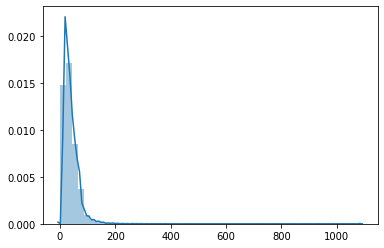

In [0]:
import seaborn as sns
import numpy as np
%matplotlib inline

wordDist = [len(w.split()) for w in data2.iloc[:,0]]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))


distIMDB = sns.distplot(wordDist)


distIMDB.figure.savefig("wordDist.pdf", format = "pdf")

We will use 300 as our maximum for the paddings

In [0]:
sequences = tokenizer.texts_to_sequences(data2.iloc[:,0]) 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


data = pad_sequences(sequences, maxlen=300, 
                     padding = 'post') 

labels = data2.iloc[:,1]
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 64711 unique tokens.
Shape of data tensor: (71644, 300)
Shape of label tensor: (71644,)


We save our output as follows:

In [0]:
!mkdir data2_Preprocessed


np.savetxt("data2_Preprocessed/data2_Padded.txt", data)
np.savetxt("data2_Preprocessed/data2_Labels.txt", labels)

In [0]:
data[0]

array([  131,   146,   134,  1269,     4,    50,    56,    29, 10718,
         140,   633,   134,  5415,   510,     6,  1651,    90,   640,
          15,     4,   111,   227,     1,    43,  2510,    31,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

We now move to constructing our embedding matrix

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))


for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector


embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.004642 , -0.083334 ,  0.023629 , ...,  0.045288 ,  0.0014906,
         0.01088  ],
       [-0.035324 ,  0.036819 ,  0.044501 , ...,  0.21608  ,  0.026943 ,
         0.043907 ],
       ...,
       [ 0.025399 , -0.0035609, -0.0026594, ...,  0.062831 , -0.059811 ,
        -0.051558 ],
       [-0.05492  ,  0.038278 , -0.014138 , ...,  0.031413 , -0.0369   ,
        -0.042412 ],
       [ 0.05704  ,  0.011737 , -0.057967 , ...,  0.038313 , -0.035208 ,
        -0.004399 ]])

In [0]:
np.savetxt("data2_EmbeddingMatrix.txt", embedding_matrix)

In [0]:
import pickle
f = open("WordDictionary.pkl","wb")
pickle.dump(word_index, f)
f.close()

In [0]:
!zip -r data2_Preprocessed.zip data2_Preprocessed 

  adding: data2_Preprocessed/ (stored 0%)
  adding: data2_Preprocessed/data2_Padded.txt (deflated 98%)
  adding: data2_Preprocessed/data2_Labels.txt (deflated 99%)


We are now ready to create our model and add the aove embedding layer to it

Glove

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
data2.head()

,text,sentiment,confidence,Num_Count,Phrase_Length,Char_Num,Upper_Count,Lower_Count
7,looking forward many uses this product am an e...,1,1.1,0,33,136,1,135
8,hi looking forward getting this product what s...,1,1.2,0,78,315,10,305
19,imran thank so much we are all so excited,1,1.3,0,10,36,3,33
29,received stencils in france there were no addi...,1,2.0,0,25,117,4,113
31,hi its great just received mine im pretty exit...,1,2.0,0,39,154,8,146


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data2['text'], data2['sentiment'], test_size=0.33, random_state=250620279)


We now move to writing the code to our Glove embedding layer which will convert our comments into numeric data

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

We then move to performing padding using 300 as our maximum length size

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("/content/drive/My Drive/Banking Analytics/Coursework #3/glove.6B.300d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

We now move to creating our Embedding Matrix as follows:

In [0]:
embedding_matrix1 = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector1 = embeddings_dictionary.get(word)
    if embedding_vector1 is not None:
        embedding_matrix1[index] = embedding_vector1

In [0]:
embedding_matrix1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.44398999,  0.12817   , -0.25246999, ..., -0.20043001,
        -0.082191  , -0.06255   ],
       [-0.18256   ,  0.49851   , -0.1639    , ..., -0.27224001,
        -0.19107001, -0.094104  ],
       ...,
       [ 0.11354   ,  0.020622  ,  0.22135   , ...,  0.33364001,
        -0.067815  ,  0.59777999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35679999, -0.21089999, -0.45232999, ..., -0.21416   ,
         0.31127   , -0.20138   ]])

**Architectures**

Kim's Model-With Softmax Embedding

In [0]:

%tensorflow_version 2.x


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=250620279, 
                                                    stratify = labels)

In [0]:
filter_sizes = (3,5,7,8)


graph_in = Input(shape=(600, 300))
convs = []
avgs = []


for fsz in filter_sizes:
    conv = Conv1D(filters=64,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) 
    pool = MaxPooling1D(pool_size=300 - fsz + 1)(conv) 
    flattenMax = Flatten()(pool) 
    convs.append(flattenMax) 
    

if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 300)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 598, 64)      57664       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 596, 64)      96064       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 594, 64)      134464      input_1[0][0]                    
________

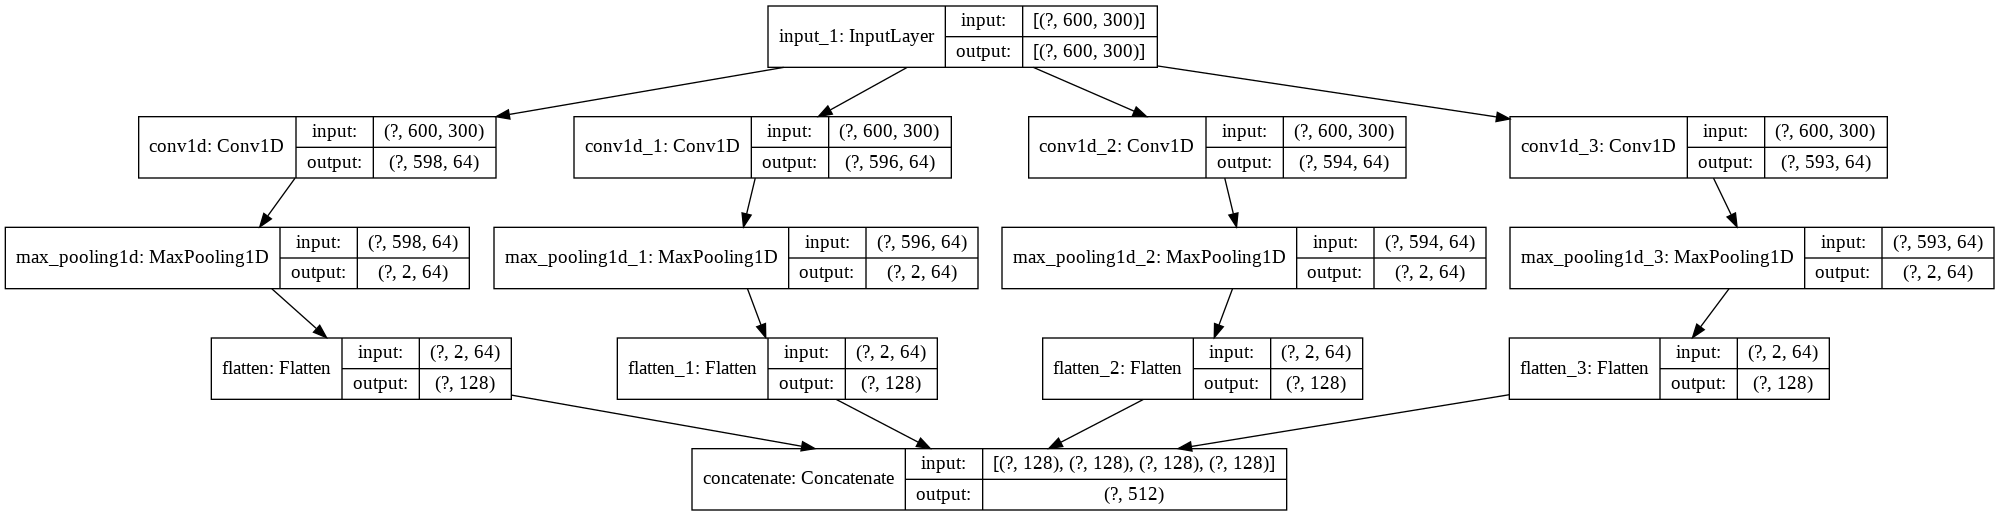

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(graph, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

In [0]:
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),          
                            300,                           
                            weights=[embedding_matrix],    
                            input_length=300,             
                            trainable=False)               

model.add(embedding_layer)


model.add(graph)


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          19413600  
_________________________________________________________________
graphModel (Model)           multiple                  441856    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,871,969
Trainable params: 458,369
Non-trainable params: 19,413,600
_________________________________________________________________


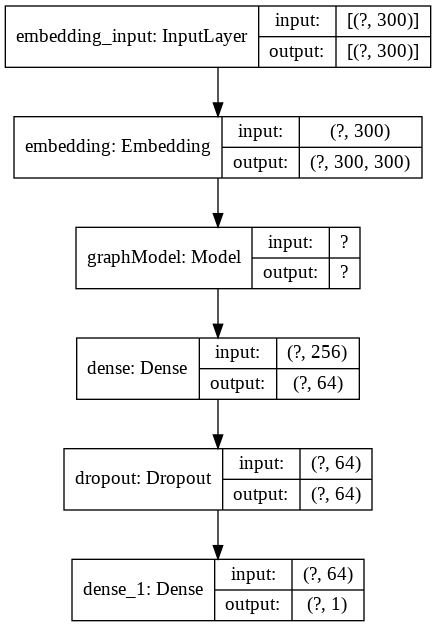

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [0]:
model.fit(X_train, y_train, validation_split=0.33, epochs=10, batch_size=5000)

Train on 32160 samples, validate on 15841 samples
Epoch 1/10
32160/32160 [==============================] - 26s 796us/sample - loss: 0.6073 - acc: 0.7009 - val_loss: 0.5531 - val_acc: 0.7003
Epoch 2/10
32160/32160 [==============================] - 14s 442us/sample - loss: 0.5190 - acc: 0.7095 - val_loss: 0.4642 - val_acc: 0.7140
Epoch 3/10
32160/32160 [==============================] - 14s 443us/sample - loss: 0.4320 - acc: 0.7730 - val_loss: 0.3835 - val_acc: 0.8370
Epoch 4/10
32160/32160 [==============================] - 14s 444us/sample - loss: 0.3633 - acc: 0.8494 - val_loss: 0.3290 - val_acc: 0.8636
Epoch 5/10
32160/32160 [==============================] - 14s 444us/sample - loss: 0.3192 - acc: 0.8687 - val_loss: 0.2953 - val_acc: 0.8728
Epoch 6/10
32160/32160 [==============================] - 14s 446us/sample - loss: 0.2905 - acc: 0.8794 - val_loss: 0.2772 - val_acc: 0.8791
Epoch 7/10
32160/32160 [==============================] - 14s 445us/sample - loss: 0.2689 - acc: 0.8896 

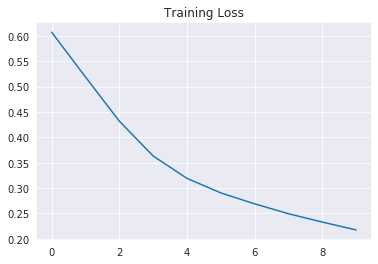

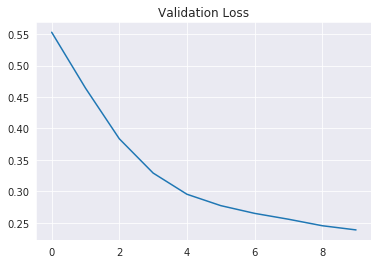

In [0]:
sns.set_style("darkgrid")
plt.plot(model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

48001/48001 [==============================] - 8s 163us/sample

AUC train:  0.9696332753515531
AUC test:  0.9633731872178599


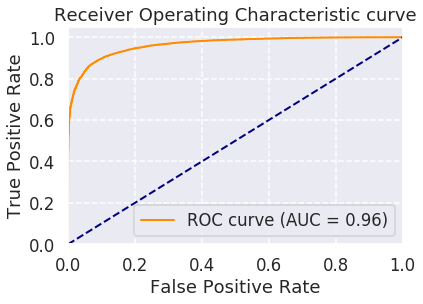

In [0]:
prob_test = model.predict(X_test, verbose = 1)
prob_train = model.predict(X_train, verbose = 1)


fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)


fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', format = "pdf")
plt.show()

In [0]:
predicted_val = pd.DataFrame(prob_test)
y = predicted_val.round()

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test,
                 y_pred = y)

array([[ 5801,  1210],
       [ 1078, 15554]])

In [0]:
predicted_val

,0
0,0.257327
1,0.925486
2,0.923907
3,0.997901
4,0.999285
...,...
23638,0.479196
23639,0.996230
23640,0.997941
23641,0.998426


Kim's Model with GloVe Embedding

In [0]:


%tensorflow_version 2.x


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=250620279, 
                                                    stratify = labels)

In [0]:
filter_sizes = (3,5,7,8)


graph_in = Input(shape=(600, 300))
convs = []
avgs = []


for fsz in filter_sizes:
    conv = Conv1D(filters=64,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) 
    pool = MaxPooling1D(pool_size=300 - fsz + 1)(conv) 
    flattenMax = Flatten()(pool) 
    convs.append(flattenMax) 
    

if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 600, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 598, 64)      57664       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 596, 64)      96064       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 594, 64)      134464      input_2[0][0]                    
_________________________________________________________________________________________

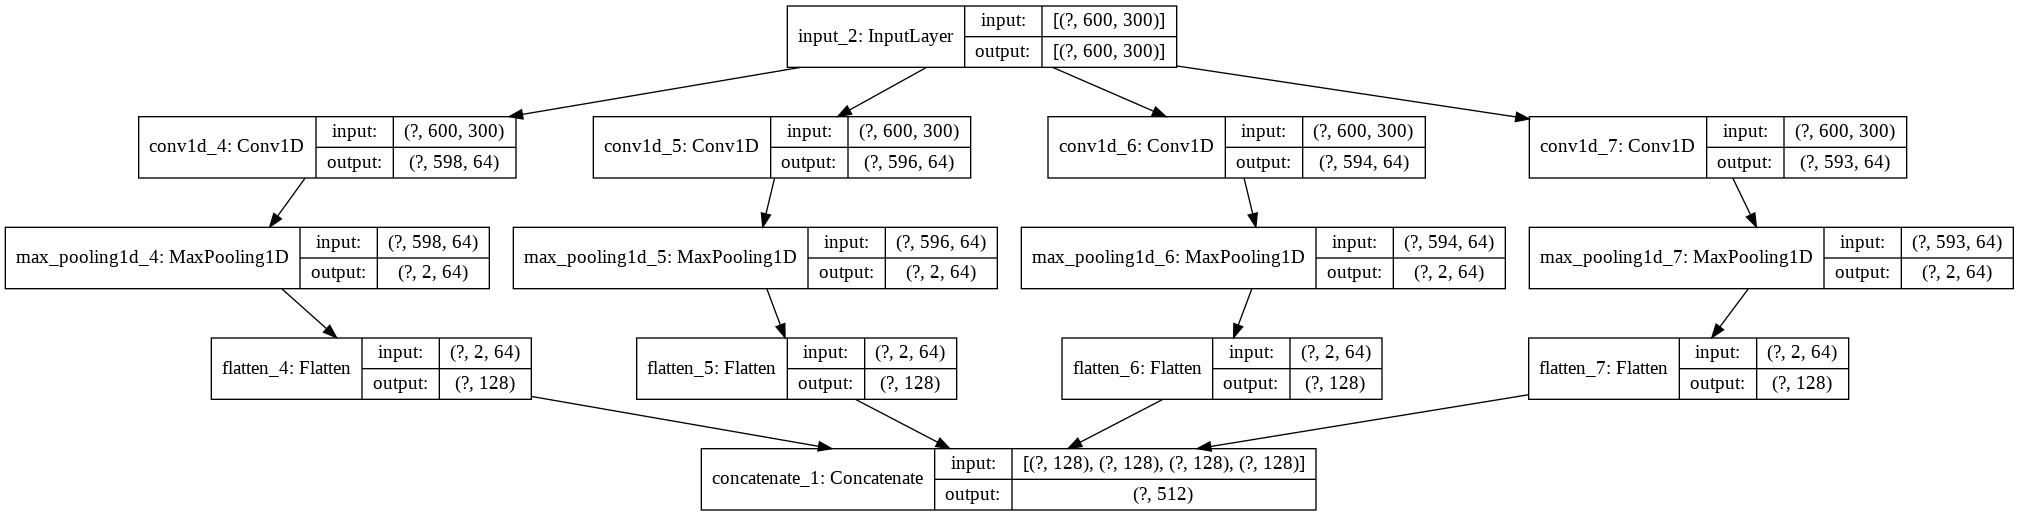

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(graph, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

In [0]:
model_0 = Sequential()
embedding_layer1 = Embedding(len(embedding_matrix1),          
                            300,                           
                            weights=[embedding_matrix1],    
                            input_length=300,             
                            trainable=False)               

model_0.add(embedding_layer1)


model_0.add(graph)


model_0.add(Dense(64, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(1, activation='sigmoid'))


model_0.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          15657600  
_________________________________________________________________
graphModel (Model)           multiple                  441856    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,115,969
Trainable params: 458,369
Non-trainable params: 15,657,600
_________________________________________________________________


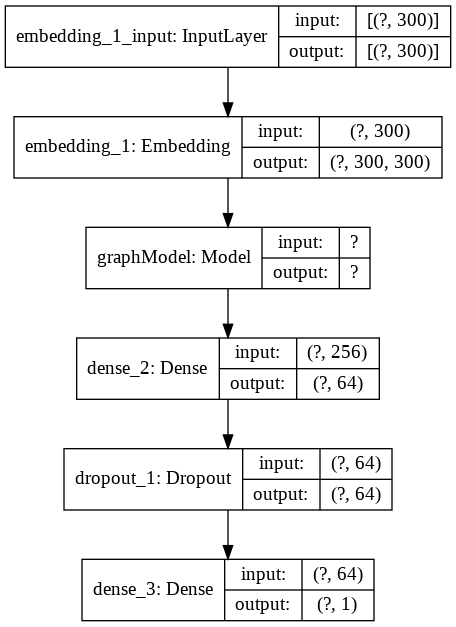

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(model_0, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [0]:
model_0.fit(X_train, y_train, validation_split=0.33, epochs=10, batch_size=5000)

Train on 32160 samples, validate on 15841 samples
Epoch 1/10
32160/32160 [==============================] - 15s 453us/sample - loss: 0.8185 - acc: 0.6317 - val_loss: 0.6393 - val_acc: 0.7157
Epoch 2/10
32160/32160 [==============================] - 14s 444us/sample - loss: 0.6170 - acc: 0.6732 - val_loss: 0.5823 - val_acc: 0.7003
Epoch 3/10
32160/32160 [==============================] - 14s 445us/sample - loss: 0.5683 - acc: 0.7070 - val_loss: 0.5413 - val_acc: 0.7017
Epoch 4/10
32160/32160 [==============================] - 14s 445us/sample - loss: 0.5265 - acc: 0.7187 - val_loss: 0.4996 - val_acc: 0.7592
Epoch 5/10
32160/32160 [==============================] - 14s 448us/sample - loss: 0.4880 - acc: 0.7507 - val_loss: 0.4654 - val_acc: 0.7705
Epoch 6/10
32160/32160 [==============================] - 14s 448us/sample - loss: 0.4500 - acc: 0.7793 - val_loss: 0.4378 - val_acc: 0.7903
Epoch 7/10
32160/32160 [==============================] - 14s 449us/sample - loss: 0.4223 - acc: 0.7983 

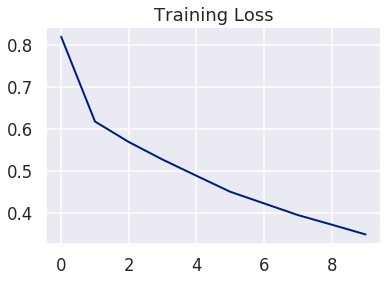

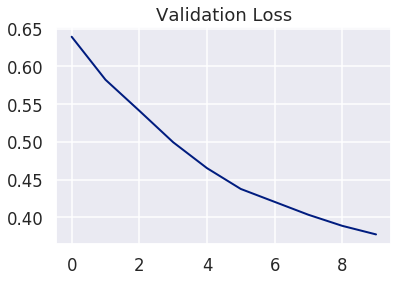

In [0]:
sns.set_style("darkgrid")
plt.plot(model_0.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model_0.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

48001/48001 [==============================] - 8s 165us/sample

AUC train:  0.9251066316548862
AUC test:  0.8979082525028181


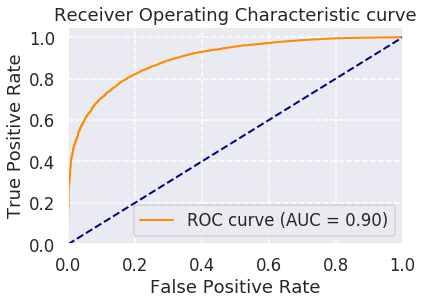

In [0]:
prob_test = model_0.predict(X_test, verbose = 1)
prob_train = model_0.predict(X_train, verbose = 1)


fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)


fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', format = "pdf")
plt.show()

In [0]:
predicted_val = pd.DataFrame(prob_test)
y = predicted_val.round()

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test,
                 y_pred = y)

array([[ 4463,  2548],
       [ 1385, 15247]])

**Sequential Architecture with FastText**

In [0]:
model1 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           
                            300,                          
                            weights=[embedding_matrix],    
                            input_length=300,              
                            trainable=False)              

model1.add(embedding_layer)

In [0]:
model1.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',      
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',       
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',       
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1.add(MaxPooling1D(pool_size = 3))

In [0]:
model1.add(Flatten())


model1.add(Dense(64, activation = 'relu'))
model1.add(Dropout(0.5))


model1.add(Dense(1, activation = 'sigmoid'))

In [0]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          19413600  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 64)           12352     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 294, 64)           12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [0]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model1.fit(X_train, y_train, validation_split=0.33, epochs=10, batch_size=5000)

Train on 32160 samples, validate on 15841 samples
Epoch 1/10
32160/32160 [==============================] - 6s 190us/sample - loss: 0.6543 - acc: 0.6806 - val_loss: 0.6151 - val_acc: 0.7003
Epoch 2/10
32160/32160 [==============================] - 3s 103us/sample - loss: 0.6064 - acc: 0.7050 - val_loss: 0.5944 - val_acc: 0.7003
Epoch 3/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.5733 - acc: 0.7050 - val_loss: 0.5261 - val_acc: 0.7003
Epoch 4/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.4856 - acc: 0.7050 - val_loss: 0.4361 - val_acc: 0.7003
Epoch 5/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.4160 - acc: 0.7051 - val_loss: 0.3990 - val_acc: 0.7004
Epoch 6/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.3864 - acc: 0.7424 - val_loss: 0.3750 - val_acc: 0.8564
Epoch 7/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.3597 - acc: 0.8359 - val_l

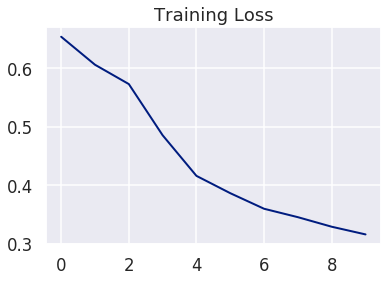

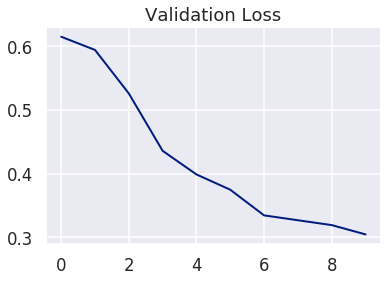

In [0]:
sns.set_style("darkgrid")
plt.plot(model1.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model1.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

48001/48001 [==============================] - 3s 69us/sample

AUC train:  0.9438606390832587
AUC test:  0.9448907385899256


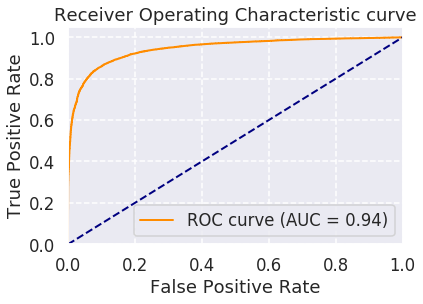

In [0]:
prob_test = model1.predict(X_test, verbose = 1)
prob_train = model1.predict(X_train, verbose = 1)


fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)


fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', format = "pdf")
plt.show()

In [0]:
predicted_val = pd.DataFrame(prob_test)
y = predicted_val.round()

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test,
                 y_pred = y)

array([[ 5645,  1366],
       [ 1331, 15301]])

**Sequential Architecture with GloVe**

In [0]:

model1_0 = Sequential()
embedding_layer1 = Embedding(len(embedding_matrix1),           
                            300,                           
                            weights=[embedding_matrix1],   
                            input_length=300,              
                            trainable=False)               

model1_0.add(embedding_layer1)

In [0]:
model1_0.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',       
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1_0.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',       
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1_0.add(Conv1D(filters=64,           
                 kernel_size=3,         
                 padding='valid',       
                 activation='relu',     
                 strides=1)             
         )

In [0]:
model1_0.add(MaxPooling1D(pool_size = 3))

In [0]:
model1_0.add(Flatten())


model1_0.add(Dense(128, activation = 'relu'))
model1_0.add(Dropout(0.5))


model1_0.add(Dense(1, activation = 'sigmoid'))

In [0]:
model1_0.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          15657600  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 298, 64)           57664     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 296, 64)           12352     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 294, 64)           12352     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
model1_0.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model1_0.fit(X_train, y_train, validation_split=0.33, epochs=10, batch_size=5000)

Train on 32160 samples, validate on 15841 samples
Epoch 1/10
32160/32160 [==============================] - 4s 113us/sample - loss: 0.6525 - acc: 0.6698 - val_loss: 0.6112 - val_acc: 0.7003
Epoch 2/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.6037 - acc: 0.7050 - val_loss: 0.5940 - val_acc: 0.7003
Epoch 3/10
32160/32160 [==============================] - 3s 103us/sample - loss: 0.5841 - acc: 0.7050 - val_loss: 0.5751 - val_acc: 0.7003
Epoch 4/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.5618 - acc: 0.7050 - val_loss: 0.5471 - val_acc: 0.7003
Epoch 5/10
32160/32160 [==============================] - 3s 103us/sample - loss: 0.5336 - acc: 0.7050 - val_loss: 0.5162 - val_acc: 0.7003
Epoch 6/10
32160/32160 [==============================] - 3s 104us/sample - loss: 0.4996 - acc: 0.7050 - val_loss: 0.4852 - val_acc: 0.7003
Epoch 7/10
32160/32160 [==============================] - 3s 105us/sample - loss: 0.4666 - acc: 0.7050 - val_l

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


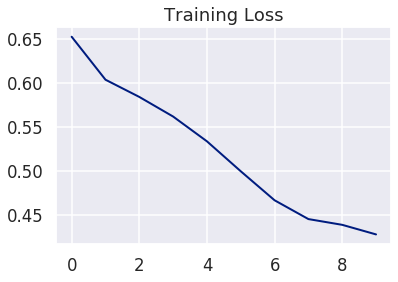

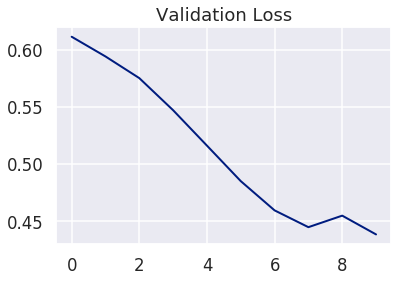

In [0]:
print(model1_0.history.history.keys())

sns.set_style("darkgrid")
plt.plot(model1_0.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model1_0.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

In [0]:

prob_test = model1_0.predict(X_test, verbose = 1)
prob_train = model1_0.predict(X_train, verbose = 1)


fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)


fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

48001/48001 [==============================] - 3s 71us/sample

AUC train:  0.8879070694577751
AUC test:  0.8793220450526826


48001/48001 [==============================] - 3s 71us/sample

AUC train:  0.8879070694577751
AUC test:  0.8793220450526826


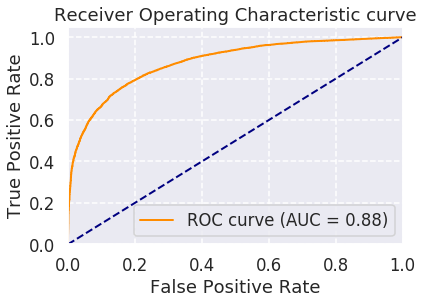

In [0]:
prob_test = model1_0.predict(X_test, verbose = 1)
prob_train = model1_0.predict(X_train, verbose = 1)


fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)


fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', format = "pdf")
plt.show()

In [0]:
predicted_val = pd.DataFrame(prob_test)
y = predicted_val.round()

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test,
                 y_pred = y)

array([[ 2405,  4606],
       [  474, 16158]])